In [1]:
import itertools
import json
import pickle
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import flowkit as fk
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import ipywidgets as widgets
from tqdm.notebook import tqdm

from utils import ask_directory
from pair_precision import (
    get_logicle_polygon_gates,
    get_pair_precisions
)


SEED = 7
np.random.seed(SEED)

In [2]:
# creat "results" folder to keep gate pairs scores and ...
Path("./results").mkdir(exist_ok=True)

In [3]:
# functions to separate alive vs. others

TIFF_NAME_FORMAT = "{name}_{id:08d}.tiff"

def get_id_from_tiff_path(tiff_path: Path):
    return int(tiff_path.stem.split("_")[-1])


def get_tiff_filtered_dataframes(dataframes: dict, sample_paths: dict):
    results = {}
    for sample_name, hdf_path in tqdm(dataframes.items(), desc="separating samples with tiff"):
        df = pd.read_hdf(hdf_path, key="df")
        image_path = sample_paths[sample_name].parent.joinpath("images")
        all_tiffs = list(image_path.glob("**/*.tiff"))
        rows_with_tiff = [get_id_from_tiff_path(img_path) for img_path in all_tiffs]
        df_with_tiff = df.iloc[rows_with_tiff]
        df_without_tiff = df.drop(index=rows_with_tiff)
        df_logicles = pd.read_hdf(hdf_path, key="logicles")
        print(
            f"{sample_name:<20}: Total: {len(df):<7,d} | With tiff: {len(df_with_tiff):<7,d} | "
            f"Without tiff: {len(df_without_tiff):,d}."
        )
        results[sample_name] = [df_without_tiff, df_with_tiff, df_logicles]

    return results

In [4]:
# load config from the previous step, if it's available
config = {}
config_file = Path("./config.json")
if config_file.exists():
    with open(config_file, mode="r") as f:
        config = json.load(f)

config

{'raw_data_dir': '/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data',
 'logicle_data_dir': '/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data'}

### Set the raw data directory (*FCS* files):

In [5]:
raw_data_dir = config.get("raw_data_dir", None)

if raw_data_dir is None:
    raw_data_dir = ask_directory("Select your data directory")

raw_data_dir = Path(raw_data_dir)
print(raw_data_dir)

/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data


In [6]:
fcs_files = raw_data_dir.glob("**/*.fcs")
sample_paths = {}
for fcs in fcs_files:
    has_images = len(list(fcs.parent.glob("*images"))) > 0
    if has_images:
        sample_paths[fcs.stem] = fcs

print("Sample files with images:")
pprint(sample_paths)

Sample files with images:
{'C.6818': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/C.6818/C.6818.fcs'),
 'Emiliana_huxley': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/Emiliana_huxley/Emiliana_huxley.fcs'),
 'Lingodinium': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/Lingodinium/Lingodinium.fcs'),
 'Phaeodactylum': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/Phaeodactylum/Phaeodactylum.fcs'),
 'Skeletonema': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/Skeletonema/Skeletonema.fcs'),
 'Synechococcus': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/Synechococcus/Synechococcus.fcs')}


### Select the Logicle transformed directory:

In [7]:
transformed_data_dir = config.get("logicle_data_dir", None)
if transformed_data_dir is None:
    transformed_data_dir = ask_directory("Select directory of the transformed data")

transformed_data_dir = Path(transformed_data_dir)
print(transformed_data_dir)

/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data


In [8]:
logicle_samples = {}
h5_files = transformed_data_dir.glob("*.h5")
for file in h5_files:
    logicle_samples[file.stem] = file

print("Logicle transformed data files:")
pprint(logicle_samples)

Logicle transformed data files:
{'C.6818': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/C.6818.h5'),
 'Emiliana_huxley': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Emiliana_huxley.h5'),
 'Lingodinium': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Lingodinium.h5'),
 'Phaeodactylum': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Phaeodactylum.h5'),
 'Skeletonema': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Skeletonema.h5'),
 'Synechococcus': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Synechococcus.h5')}


### Separating alive samples vs. others for each species:

In [9]:
species_dfs = get_tiff_filtered_dataframes(logicle_samples, sample_paths)

separating samples with tiff:   0%|          | 0/6 [00:00<?, ?it/s]

Synechococcus       : Total: 11,927  | With tiff: 10,000  | Without tiff: 1,927.
Lingodinium         : Total: 893,258 | With tiff: 1,276   | Without tiff: 891,982.
C.6818              : Total: 299,976 | With tiff: 2,967   | Without tiff: 297,009.
Phaeodactylum       : Total: 238,981 | With tiff: 10,000  | Without tiff: 228,981.
Skeletonema         : Total: 540,631 | With tiff: 10,000  | Without tiff: 530,631.
Emiliana_huxley     : Total: 126,206 | With tiff: 10,000  | Without tiff: 116,206.


### Select the target species:

In [10]:
selector = widgets.Select(
    options=[sp_name for sp_name in species_dfs],
    rows=14,
    description="Target species:"
)

display(selector)

Select(description='Target species:', options=('Synechococcus', 'Lingodinium', 'C.6818', 'Phaeodactylum', 'Ske…

In [11]:
target_species = selector.value
print(f"Your target species: {target_species}")

Your target species: Lingodinium


In [12]:
# get the target alive samples
df_alive = species_dfs[target_species][1]

# get others species samples
df_others = []
for name in species_dfs:
    if name != target_species:
        df_others.append(species_dfs[name][0])
        df_others.append(species_dfs[name][1])

df_others = pd.concat(df_others)


print(f"alive: {df_alive.shape}, others: {df_others.shape}")

alive: (1276, 421), others: (1217721, 421)


In [13]:
# to free some memory up
del species_dfs

### Normalize the data

In [14]:
scaler = StandardScaler()

scaler.fit(np.vstack((
    df_alive.to_numpy(),
    df_others.to_numpy()
)))

StandardScaler()

In [15]:
alive_normed = scaler.transform(df_alive.to_numpy())
others_normed = scaler.transform(df_others.to_numpy())

### Get the Fisher Discriminant Ratio (FDR) for each channel:
(For two classes alive vs. others)

In [16]:
alive_mu = alive_normed.mean(axis=0)
others_mu = others_normed.mean(axis=0)

alive_vars = alive_normed.var()
others_vars = others_normed.var()

In [17]:
fishers = np.power(alive_mu - others_mu, 2) / (alive_vars + others_vars)
fishers.shape

(421,)

In [18]:
df_fisher = pd.DataFrame(data={
    "channel": df_alive.columns, "fisher": fishers
}).sort_values("fisher", ascending=False).reset_index(drop=True)

df_fisher

,channel,fisher
0,Size (Green*),25.315002
1,Size (Orange*),11.394045
2,B3 (530)-H,8.771157
3,V7 (530)-H,8.738846
4,V6 (515)-H,8.642836
...,...,...
416,Eccentricity (FSC),0.003395
417,FSC-W,0.001510
418,Eccentricity (SSC (Imaging)),0.001065
419,Eccentricity (LightLoss (Imaging)),0.000420


### Get fisher score for each possible pair (average of two channels in a pair)

In [19]:
all_pairs_cols = np.array(
    list(itertools.combinations(df_alive.columns.to_list(), 2))
)

pprint(all_pairs_cols)

array([['FSC-A', 'FSC-H'],
       ['FSC-A', 'FSC-W'],
       ['FSC-A', 'SSC (Violet)-A'],
       ...,
       ['R6 (780)-T', 'R7 (810)-T'],
       ['R6 (780)-T', 'R8 (845)-T'],
       ['R7 (810)-T', 'R8 (845)-T']], dtype='<U45')


In [20]:
pair_fishers = np.zeros(len(all_pairs_cols))

for i, pair in tqdm(
    enumerate(all_pairs_cols), total=len(all_pairs_cols), desc="Getting pairs' fishers"
):
    # print(pair)
    fisher_col1 = df_fisher[df_fisher["channel"] == pair[0]]["fisher"].to_numpy()[0]
    fisher_col2 = df_fisher[df_fisher["channel"] == pair[1]]["fisher"].to_numpy()[0]
    pair_fishers[i] = (fisher_col1 + fisher_col2) / 2

Getting pairs' fishers:   0%|          | 0/88410 [00:00<?, ?it/s]

In [21]:
df_pair_fishers = pd.DataFrame(data={
    "channel_1": all_pairs_cols[:, 0],
    "channel_2": all_pairs_cols[:, 1],
    "fisher_avg": pair_fishers
})

df_pair_fishers = df_pair_fishers.round(4).sort_values(
    "fisher_avg", ascending=False).reset_index(drop=True)
df_pair_fishers

,channel_1,channel_2,fisher_avg
0,Size (Green*),Size (Orange*),18.3545
1,Size (Green*),B3 (530)-H,17.0431
2,Size (Green*),V7 (530)-H,17.0269
3,Size (Green*),V6 (515)-H,16.9789
4,Size (Green*),B2 (515)-H,16.8348
...,...,...,...
88405,FSC-W,Eccentricity (LightLoss (Imaging)),0.0010
88406,FSC-W,Eccentricity (Red*),0.0008
88407,Eccentricity (SSC (Imaging)),Eccentricity (LightLoss (Imaging)),0.0007
88408,Eccentricity (SSC (Imaging)),Eccentricity (Red*),0.0005


### Top Pairs: 

#### 1. Select pairs with fisher score above the average

In [22]:
fisher_mean = df_pair_fishers["fisher_avg"].mean().round(4)
print(fisher_mean)

2.0827


In [23]:
mask = df_pair_fishers["fisher_avg"] > fisher_mean
df_pair_fisher_above_mean = df_pair_fishers[mask].reset_index(drop=True)

df_pair_fisher_above_mean

,channel_1,channel_2,fisher_avg
0,Size (Green*),Size (Orange*),18.3545
1,Size (Green*),B3 (530)-H,17.0431
2,Size (Green*),V7 (530)-H,17.0269
3,Size (Green*),V6 (515)-H,16.9789
4,Size (Green*),B2 (515)-H,16.8348
...,...,...,...
37463,Correlation (Green*/Red*),UV5 (460)-H,2.0831
37464,UV3 (420)-H,R5 (750)-T,2.0830
37465,Radial Moment (Green*),UV15 (655)-A,2.0829
37466,Short Axis Moment (Red*),R2 (675)-T,2.0829


#### 2. For each channel selected by the previous step, select pairs with having fisher score above the 50% (median):

In [24]:
def get_top_pairs(channel_list, df_fisher):
    best_matches = []
    for channel in tqdm(channel_list, desc="Proposing best matches"):
        ch_mask = df_fisher["channel_1"] == channel
        if ch_mask.sum() > 0:
            channel_pairs = df_fisher[ch_mask].sort_values("fisher_avg", ascending=False)
            ch_threshold = np.quantile(channel_pairs["fisher_avg"], 0.5)
            top_matches = channel_pairs[channel_pairs["fisher_avg"] >= ch_threshold]
            best_matches.append(top_matches)

    return pd.concat(best_matches).reset_index(drop=True)

In [25]:
df_top_pairs = get_top_pairs(df_alive.columns.to_list(), df_pair_fisher_above_mean)
df_top_pairs

Proposing best matches:   0%|          | 0/421 [00:00<?, ?it/s]

,channel_1,channel_2,fisher_avg
0,FSC-A,Size (Green*),13.1069
1,FSC-A,Size (Orange*),6.1465
2,FSC-A,B3 (530)-H,4.8350
3,FSC-A,V7 (530)-H,4.8189
4,FSC-A,V6 (515)-H,4.7709
...,...,...,...
18792,R8 (845)-H,UV2 (390)-T,2.6285
18793,R8 (845)-H,B13 (750)-T,2.6280
18794,R8 (845)-H,V2 (440)-W,2.6267
18795,R8 (845)-H,R4 (725)-W,2.6265


In [26]:
# save the top pairs
df_top_pairs.to_csv(f"./results/{target_species}_top_pairs.csv", index=False)

### Get the average vector of the alive samples (with images) for the target species.

In [27]:
# get the target species data in logicle space
df_positive_logicle = pd.read_hdf(logicle_samples[target_species], key="df")
df_positive_logicle.shape

(893258, 421)

In [28]:
# get channel's logicle params
df_logicle_params = pd.read_hdf(logicle_samples[target_species], key="logicles")
df_logicle_params.shape

(421, 4)

In [29]:
# alive (with tiffs) samples average vector
target_alive_vector = df_alive.mean().to_numpy()
# np.save(f"./results/{target_species}_alive_vector.npy", target_alive_vector)
target_alive_vector.shape

(421,)

### Calculate the similarity between all samples with the alive average vector.

In [30]:
# calculate the cosine similarity between alive average vector and each row of data
data = df_positive_logicle.to_numpy()
sim_mat = np.dot(data, target_alive_vector)
sim_mat /= (
    np.linalg.norm(data, axis=1) *
    np.linalg.norm(target_alive_vector)
)
# print(sim_mat.min(), sim_mat.max(), sim_mat.mean())

# add weights to make a better distribution of the similarities
weights = (sim_mat - np.mean(sim_mat))
sim_mat = weights * sim_mat

# scale similarity to the range of [0, 1]
sim_mat = (sim_mat - sim_mat.min()) / (sim_mat.max() - sim_mat.min())
# print(sim_mat.min(), sim_mat.max(), sim_mat.mean())

### Set the threshold of the similarity:
##### Higher threshold will produce tighter gate with more pure samples but less in numbers.

In [41]:
# threshold the similarity
threshold_slider = widgets.FloatSlider(
    value=0.85,
    min=0,
    max=1.0,
    step=0.01,
    description="Similarity Threshold:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format='.2f',
)
display(threshold_slider)

FloatSlider(value=0.85, continuous_update=False, description='Similarity Threshold:', max=1.0, step=0.01)

In [44]:
similarity_threshold = threshold_slider.value
print(similarity_threshold)

high_sim_mask = sim_mat > similarity_threshold
np.save(f"./results/{target_species}_high_sim_mask.npy", high_sim_mask)
print(f"Alive-Similar data rows: {high_sim_mask.sum():,d}")

0.9
Alive-Similar data rows: 3,371


#### Visualize the threshold effect on a sample pair

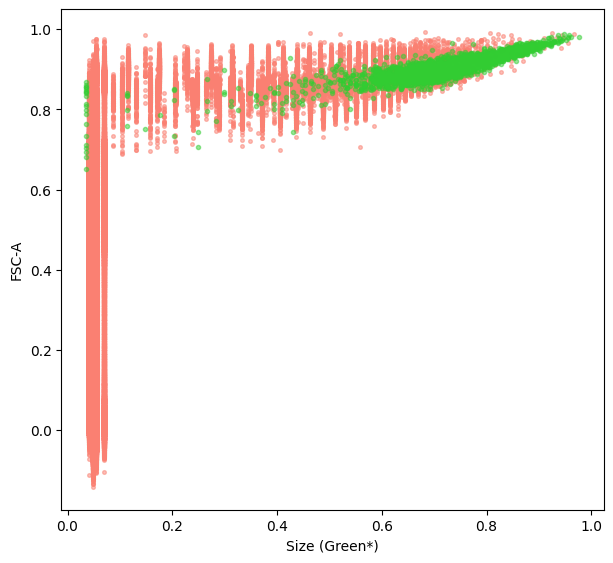

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))

ch1 = df_top_pairs.loc[0, "channel_1"]
ch2 = df_top_pairs.loc[0, "channel_2"]

ax.scatter(
    df_others[ch2].to_numpy(), df_others[ch1].to_numpy(),
    color="salmon", s=7, alpha=0.5
)
ax.scatter(
    df_positive_logicle[ch2].to_numpy()[high_sim_mask], df_positive_logicle[ch1].to_numpy()[high_sim_mask],
    color="limegreen", s=9, alpha=0.5
)

ax.set_xlabel(ch2)
ax.set_ylabel(ch1)

plt.show()

### Create the polygon gates for the selected top pairs:

In [47]:
logicle_polygon_gates = get_logicle_polygon_gates(df_top_pairs, df_positive_logicle, high_sim_mask)

len(logicle_polygon_gates)

Calculate pairs' polygon gates (logicle):   0%|          | 0/18797 [00:00<?, ?it/s]

18797

In [48]:
# saving gates
pairs = [
    f"{channels[0]}|{channels[1]}" for channels in
    df_top_pairs[["channel_1", "channel_2"]].itertuples(index=False, name=None)
]

# with open(f"./results/{target_species}_top_gates.bin", mode="wb") as f:
#     pickle.dump({
#         pair:gate for pair, gate in zip(pairs, logicle_polygon_gates)
#     }, f)

In [49]:
# to free up some memory

del df_others
del df_positive_logicle
del weights
del sim_mat
del data

### Calculate the precision for each pair/gate

In [50]:
# load raw data to make positive and negative dataframes
df_positive = fk.Sample(sample_paths[target_species]).as_dataframe(source="raw")

df_negative = []
for sample_name in logicle_samples:
    fcs_file = sample_paths[sample_name]
    if sample_name != target_species:
        df_negative.append(
            fk.Sample(fcs_file).as_dataframe(source="raw")
        )
df_negative = pd.concat(df_negative)

# !important: drop second level columns (pns)
df_positive = df_positive.droplevel(level=1, axis=1)
df_negative = df_negative.droplevel(level=1, axis=1)

print(df_positive.shape, df_negative.shape)

(893258, 450) (1217721, 450)


In [ ]:
# (Takes time!)
df_precisions = get_pair_precisions(
    df_top_pairs, logicle_polygon_gates, df_logicle_params,
    df_positive, df_negative
)

Calculate gate precisions:   0%|          | 0/18797 [00:00<?, ?it/s]

In [ ]:
# df_precisions = df_precisions.sort_values("precision", ascending=False).reset_index(drop=True)
df_precisions

In [ ]:
df_precisions.to_csv(f"./results/{target_species}_gate_precisions.csv", index=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6.5))
ax.scatter(
    df_precisions["precision"], df_precisions["fisher_avg"],
    color="dodgerblue", s=11, lw=0
)
ax.set_title(target_species)
ax.set_xlabel("Precision")
ax.set_ylabel("Fisher Ratio")
ax.grid(alpha=0.3)

plt.show()